## Solving Brock-Mirman optimal growth model with PI

#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np

# This is used to calculate the excution time of several loops
import time

import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline 

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The functions lgwt and acm are copied below.

In [2]:
def lgwt(N,a,b):
    """ Syntax: [x,w]=lgwt(N,a,b)
    
    This script is for computing definite integrals using Legendre-Gauss 
    Quadrature. Computes the Legendre-Gauss nodes and weights on an interval
    [a,b] with truncation order N.
    
    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using sum(f.*w);
    
    Translated from Greg von Winckel's Matlab Script written on 02/25/2004
    """

    N = N-1
    N1 = N+1; N2 = N+2;

    xu = np.linspace(-1,1,N1)

    # Initial guess
    y=np.cos((2*np.arange(0,N+1)+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)

    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method

    y0=2

    # Iterate until new points are uniformly within epsilon of old points
    while np.abs(y-y0).max() > np.finfo(float).eps:
        
        # Legendre-Gauss Vandermonde Matrix
        L=np.zeros((N1,N2))

        # Derivative of LGVM
        Lp=np.zeros((N1,N2))
        
        L[:,0]=1
        Lp[:,0]=0

        L[:,1]=y
        Lp[:,1]=1
        
         
        for k in np.arange(1,N1):
            L[:,k+1]=( (2*(k+1)-1)*y*L[:,k]-((k+1)-1)*L[:,k-1] )/(k+1)

            
        Lp=(N2)*(L[:,N1-1]-y*L[:,N2-1] )/(1-y**2)

        y0=y.copy()
        y=y0-L[:,N2-1]/Lp


    # Linear map from[-1,1] to [a,b]
    x = ((a*(1-y)+b*(1+y))/2).T

    # Compute the weights
    w = ((b-a)/((1-y**2)*Lp**2)*(N2/N1)**2).T
       
    return x, w

In [3]:
# scipy.stats.norm: a normal continuous random variable.
from scipy.stats import norm

# needed for Gauss-Lobatto only
from scipy.integrate import quad

# Adda-Cooper's method of approximating an AR(1) process with normally distributed innovation.
def acm(mu,rho,sigma,n,me=1):
    """ Syntax: [ss,tm,sd,sm,ssd,sac] = acm(mu,rho,sigma,n,me) 

    ss is state space, tm is transition matrix, sd is stationary distribution,
    sm is stationary mean, ssd is stationary standard deviation and sac is 
    stationary autocorrelation. mu is the mean of the AR process, rho is 
    the autocorrelation and sigma is the standard deviation of the innovation.
    n is the number of states and me stands for the method used in numerical integration.
    """
    
    tm = np.zeros((n,n))
    sg = sigma / (np.sqrt(1 - rho**2))     # sg is the variance of AR process
    
    # n + 1 interval nodes for defining the states, trucated at two ends.
    node = sg * norm.ppf(np.arange(0,n+1) / n + np.concatenate((np.array([np.spacing(1)]), np.zeros((1,7 - 1))[0],\
                                                                    (np.array([-np.spacing(1)]))))) + mu
    

    # lengths of n intervals.
    itv = node[1:n + 1] - node[0:n]
    

    ss = n * sg * (norm.pdf((node[0:n] - mu) / sg) - norm.pdf((node[1:n+1] - mu) / sg)) + mu
    
    # itvu is the upper bound of an interval, itvl likewise.
    f = lambda u,itvu,itvl: np.exp(-(u - mu)**2 / 2 / sg**2)*\
    (norm.cdf((itvu - mu*(1 - rho) - rho*u)/sigma) -\
     norm.cdf((itvl - mu*(1 - rho) - rho*u)/sigma)) / np.sqrt(2 * np.pi) / sg
    
    
    match me:
        case 1:
            # use Gauss-Legendre method

            # Generate 10 nodes and corresponding weights using Winckel's function lgwt.
            m = 10
            x,w = lgwt(m,-1,1)    

            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                tm[i,:] = 0.5 * itv * (np.matmul(w,f_i(np.matmul((x + 1)[:,np.newaxis], itv[np.newaxis,:]) / 2 \
                                                    + np.ones((m,1)) * node[0:n])))

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])
                

            stop = time.perf_counter()
            print("Time of the Gauss-Legendre method is:", round(stop - start,4))

        
        case 2:
            # use recursive adaptive Gauss-Lobatto quadrature
            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                for j in np.arange(0,n):
                    tm[i,j] = quad(f_i,node[j],node[j + 1])[0]

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])

            stop = time.perf_counter()
            print("Time of Gauss-Lobatto method is:", round(stop - start,4))

    sd = np.dot((np.concatenate((np.zeros((1,n - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[:,0:n - 1] - np.eye(n,n - 1),np.ones((n,1)),1))))
    sd = sd / sum(sd)
    sm = np.dot(sd, ss)
    ssd = np.sqrt(np.dot((ss - sm)**2, sd.T))

    sac = (np.matmul((ss[:,np.newaxis] - sm),ss[np.newaxis,:] - sm) *\
           np.matmul(np.diag(sd),tm)).sum(axis=1).sum(axis=0) / ssd**2
        
        
    return ss,tm,sd,sm,ssd,sac

### user defined functions for solving the problem:

In [4]:
def kronv(x,y):
    # Compute kroneck product of two column vector using basic
    # built-in functions for array manipulation instead of using
    # another built-in function kron, which involves non-basic
    # functions like meshgrid.
    
    # only accepts two-dimensional numpy arrays as inputs
    
    nx = x.size
    ny = y.size

    z = np.reshape(np.matmul(y,x.T),nx * ny,order="F")
    return z

def kronm(x,y):
    # Compute kroneck product of two matrices using kronv
    # only accepts two-dimensional numpy arrays as inputs
    
    nx,kx = x.shape
    ny,ky = y.shape
    
    z = np.zeros((nx * ny,kx * ky))
    for l in np.arange(0,kx):
        for m in np.arange(0,ky):
            z[:,l * ky + m] = kronv(x[:,l][:,np.newaxis],y[:,m][:,np.newaxis])
    
    return z

In [5]:
def linitp(x,x_grid,y_grid):
    # x_grid is a vector summarizing the information of the grid of x,
    # including the lower bound x_grid(1) and step size x_grid(2).
    # y_grid has the same number of columns as x, while the length of x
    # could be greater than y_grid. Users are required to make
    # sure x lies in the admissible region.

    k = x.shape[0]
    n,m = y_grid.shape

    Ix = np.fix((x - x_grid[0]) / x_grid[1])
    w = (x - x_grid[0]) / x_grid[1] - Ix

    arr_index1 = (np.maximum(Ix,0).astype(int),\
                 np.matmul(np.ones((k,1)), np.arange(0,m)[np.newaxis,:]).astype(int))
    #ind1 = np.ravel_multi_index(arr_index1, (n,m), order='F') # equivalent to sub2ind in Matlab
    
    arr_index2 = (np.minimum(Ix+1,n-1).astype(int),\
                  np.matmul(np.ones((k,1)), np.arange(0,m)[np.newaxis,:]).astype(int))

    #ind2 = np.ravel_multi_index(arr_index2, (n,m), order='F') # equivalent to sub2ind in Matlab
    
    #y_gridf = y_grid.flatten('F')
    #y = (1 - w) * y_gridf[ind1] + w * y_gridf[ind2]

    y = (1 - w) * y_grid[arr_index1] + w * y_grid[arr_index2]

    return y


In [6]:
# utility function
def fu(x, gamma):
    if gamma == 1:
        y = np.log(x)
    else:
        y = x**(1 - gamma)/(1 - gamma)
        
    return y


# production function
def fprod(x, alpha):
    y = x**alpha
    return y

In [7]:
from scipy.optimize import root,fsolve

def fv(gc,gk,tmt,ssk_grid,beta,gamma):
    # solve for value function using gc, gk and tmt
    
    u = fu(gc,gamma)  # current utility
    
    # functional equation for v
    # scipy.optimize victorizes the input and output of the function, 
    # so we must reshape the input v to its original shape, and we must flatten the output of the function
    fneq = lambda v: (u + beta * np.matmul(linitp(gk,ssk_grid,v.reshape(gk.shape)),tmt) - v.reshape(gk.shape)).flatten()
    
    v0 = 1 * u / (1 - beta)

    v = root(fneq,v0,method="lm").x.reshape(gk.shape)
    # or we can use the following:
    #v = opt.fsolve(fneq,v0,method="lm").reshape(gk.shape)
    return v

In [8]:
# Use value function interpolation or policy function iteration to solve
# Brock-Mirman optimal growth model.

# This is used for the fminbound function
from scipy.optimize import fminbound

def growthvipi(me,vime,PAR, DSS, SSK, SSS, TM):
    """ Syntax: [v,gk,gc,gi,gy,t] = bmvipi(me,vime,PAR DSS SSK SSS TM) 

    me = 1 corresponds to value function interpolation and me = 0
    corresponds to policy function iteration. vime indicates the method used
    in value function interpolation, with vime = 0 referring to discrete
    maximization and vime = 1 referring to sophiscated optimization (fminbnd alike).
    """
    #--------------------------------------------------------------------------

    # vful_j is used to define maxv in value function iterpolation with continuous optimization
    alpha = PAR[0]
    beta = PAR[1]
    delta = PAR[2]
    gamma = PAR[3]
    bk = DSS[0]  # use the syntax b* to denote steady state value
    bc = DSS[1]
    ssk = SSK  # nkx1
    nk = ssk.size
    sss = SSS.T     # ns x1
    ns = sss.size
    tmt = TM
    
    t = {'pi':0,'vi_dsc':0,'vi_ctn':0}
    ssk_grid = np.array([ssk[0],(ssk[-1] - ssk[0]) / (nk - 1)])
    # ssk_grid is used by all methods.
    
    #--------------------------------------------------------------------------
    
    
    if me == 0:
        # use policy iteration with linear iterpolation
        tm1 = kronm(tmt,np.append(1,np.zeros((1,ns)))[np.newaxis,:])
        tm1 = np.reshape(tm1[:,0:ns**2],(ns**2,ns),order="F")    # for computing E_t...
        
        gk_new = (1 - (1 - alpha) * delta) * np.matmul((ssk - bk)[:,np.newaxis], np.ones((1,ns)))\
        + bk * np.matmul(np.ones((nk,1)), (1 * (sss[np.newaxis,:] - 1) + 1))
                
        gk_new = np.maximum(gk_new,ssk[0])
        gk_new = np.minimum(gk_new,ssk[-1])
        # This choice is motivated by the approximation around steady state.
        
        gk_old = np.zeros((nk,ns))
        tol = np.linalg.norm(gk_old - gk_new,1)
        nitr = 0
        
        start = time.perf_counter()
        while tol > 1e-6 and nitr <= 2500:
            gk_old = gk_new.copy()
            
            # Note: using numpy.kron is much faster than using the basic kronm function that is defined here
            
            k1 = kronm(gk_old, np.ones((1,ns)))  # array of k_t+1
            k2 = linitp(k1,ssk_grid,kronm(np.ones((1,ns)),gk_old))  # array of k_t+2
            
            c1 = kronm(fprod(gk_old,alpha),sss[np.newaxis,:]) + (1 - delta) * k1 - k2 # array of c_t+1
            c1 = np.maximum(c1,1e-6) # prohibit zero consumption

            mp = 1 - delta + alpha * kronm(gk_old**(alpha - 1),sss[np.newaxis,:]) # array of marginal productivity
            
            gc = (beta * np.matmul(c1**(-gamma) * mp, tm1))**(-1 / gamma)
            
            gk_new = np.matmul(fprod(ssk[:,np.newaxis],alpha), sss[np.newaxis,:]) + (1 - delta) *\
            np.matmul(ssk[:,np.newaxis], np.ones((1,ns))) - gc
            
            gk_new = np.maximum(gk_new,ssk[0])
            gk_new = np.minimum(gk_new,ssk[-1])
            tol = np.linalg.norm(gk_old - gk_new,1)
            nitr = nitr + 1
            print("iteration = ", nitr, ", tolerance = ", tol, sep='')

        stop = time.perf_counter()
        t['pi'] = stop - start
        print("Elapsed time in seconds for the while loop (policy iteration) is:", round(t['pi'],4))   
        print('Number of iterations of the while loop:', nitr)
        
        gk = gk_new.copy()
        gi = gk - (1 - delta) * np.dot(ssk[:,np.newaxis], np.ones((1,ns)))
        gy = gi + gc
        v = fv(gc,gk,tmt,ssk_grid,beta,gamma)
        
        
        
    elif me == 1 and vime == 0:
        # Use value function iteration with linear iterpolation
        # Use discrete maximization
        
        vnew = 1 * fu(bc,gamma) * np.ones((nk,ns)) / (1 - beta) 
        vold = np.zeros((nk,ns))
        nkd = 50 * nk
        # A denser space for k'.
        sskd = np.linspace(ssk[0],ssk[-1],nkd) # nkd x 1
        
        iv = kronv(np.ones((nk,1)), sskd[:,np.newaxis]) - kronv((1 - delta) * ssk[:,np.newaxis], np.ones((nkd,1)))
        iv = kronv(np.ones((ns,1)),iv[:,np.newaxis])
        
        # 7x1, nk*nkd x 1 = nk*nkd*ns x 1
        c = kronv(sss[:,np.newaxis],kronv(fprod(ssk[:,np.newaxis],alpha),np.ones((nkd,1)))[:,np.newaxis]) - iv
        
        del iv
        
        u = -0.5 * np.finfo(float).max * np.ones((nkd * nk * ns,))
        Ic = np.argwhere(c > 0)
        u[Ic] = fu(c[Ic],gamma)
        u = u.reshape((nkd,nk,ns),order="F")
        
        tol = np.linalg.norm(vnew - vold,1)
        nitr = 0
        
        start = time.perf_counter()
        while tol > 1e-6 and nitr <= 2500:
            vold = vnew.copy()
            vful = np.matmul(vold, tmt)
            vfuld = linitp(np.matmul(sskd[:,np.newaxis], np.ones((1,ns))),ssk_grid,vful)

            # Using the built-in numpy.kron is much faster than using the basic kronm and kronv 
            #vfuld = np.reshape(kronm(np.ones((nk,1)),vfuld),(nkd,nk,ns), order='F')
            vfuld = np.reshape(np.kron(np.ones((nk,1)), vfuld), (nkd,nk,ns), order='F') 

            #vnew = (u + beta * vfuld).max(axis=0,keepdims=True)
            #vnew = np.reshape(vnew,(nk,ns))
            #vnew = (u + beta * vfuld).max(axis=0)
            vnew = np.amax(u + beta * vfuld, axis=0)
            
            tol = np.linalg.norm(vnew - vold,1)
            nitr = nitr + 1
            print("iteration = ", nitr, ", tolerance = ", tol, sep='')

        stop = time.perf_counter()
        t['vi_dsc'] = stop - start
        print("Elapsed time in seconds for the while loop (discrete value function iteration) is:", round(t['vi_dsc'],4))   
        print('Number of iterations of the while loop:', nitr)
        
        vful = np.dot(vnew, tmt)
        vfuld = linitp(np.dot(sskd[:,np.newaxis], np.ones((1,ns))),ssk_grid,vful)
        vfuld = np.reshape(kronm(np.ones((nk,1)), vfuld), (nkd,nk,ns), order='F')

        v, Igk = (u + beta * vfuld).max(axis=0), (u + beta * vfuld).argmax(axis=0) # Igk contains indices of gk
        gk = sskd[Igk]
        gi = gk - (1 - delta) * np.dot(ssk[:,np.newaxis], np.ones((1,ns)))
        gy = np.dot(fprod(ssk[:,np.newaxis],alpha), sss[np.newaxis,:])
        gc = gy - gi 
        
        
    else:
        # Use fminbnd to optimize
        gk = np.zeros((nk,ns))
        y = np.dot(fprod(ssk[:,np.newaxis],alpha), sss[np.newaxis,:]) \
        + (1 - delta) * np.dot(ssk[:,np.newaxis], np.ones((1,ns))) # Disposable income.
        
        vnew = 1 * fu(bc,gamma) * np.ones((nk,ns)) / (1 - beta) 
        vold = np.zeros((nk,ns))
        
        
        
        tol = np.linalg.norm(vnew - vold,1)
        nitr = 0
        
        start = time.perf_counter()
        while tol > 1e-6 and nitr <= 2500:
            vold = vnew.copy()
            vful = np.matmul(vold, tmt)
            for i in np.arange(0,nk):
                for j in np.arange(0,ns):
                    gk[i,j], vnew[i,j], = fminbound(func=lambda k1: -fu(y[i,j]-k1,gamma)-\
                                                    beta*linitp(np.array([[k1]]),ssk_grid,vful[:,j][:,np.newaxis]),\
                                                    x1=ssk[0],x2=min(y[i,j],ssk[-1]),xtol=1e-04,full_output=1)[0:2]
                    
                    # A pitfall: one needs to make sure ssk[0] is less than
                    # y[i,j]. So long as ssk contains the ergodic set of k,
                    # this condition is guaranteed.
            

            vnew = -vnew
            tol = np.linalg.norm(vnew - vold,1)
            nitr = nitr + 1
            print("iteration = ", nitr, ", tolerance = ", tol, sep='')

        stop = time.perf_counter()
        t['vi_ctn'] = stop - start
        print("Elapsed time in seconds for the while loop (continuous value function iteration) is:", round(t['vi_ctn'],4))   
        print('Number of iterations of the while loop:', nitr)
            
        v = vnew.copy()
        gi = gk - (1 - delta) * np.dot(ssk[:,np.newaxis], np.ones((1,ns)))
        gy = np.dot(fprod(ssk[:,np.newaxis],alpha), sss[np.newaxis,:])
        gc = gy - gi
        
    
    return v,gk,gc,gi,gy,t

In [9]:
alpha = 0.36
beta = 0.99
gamma = 1       # log utility
delta = 0.025
PAR = np.array([alpha,beta,delta,gamma])


In [10]:
bk = (1 / beta / alpha + (delta - 1) / alpha)**(1 / (alpha - 1))
bi = delta * bk
bc = bk**alpha - bi
DSS = np.array([bk,bc,bi])


In [11]:
SSS, TM = acm(0,0.95,0.00712,7,1)[0:2]
SSS = np.exp(SSS)     # acm returns the log productivity shock


Time of the Gauss-Legendre method is: 0.0018


In [12]:
krange = np.array([0.9,1.1])
nk = 200
SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk)  #kgrid


In [13]:
print('Method for solving the model:\n')
print('-- 1 policy iteration with interpolation\n')
print('     and discrete maximization;\n')
print('-- 2 value function iteration with interpolation\n')
print('     and discrete maximization;\n')
print('-- 3 value function iteration with interpolation\n')
print('     and continuous maximization.\n')

while True:
    try:
        me = int(input('-- '))
    except ValueError:
        print("Please enter a valid integer [1-2-3]")
        continue
    else:
        if me not in [1,2,3]:
            print("Please enter a valid integer [1-2-3]")
            continue
        else:
            print(f'You entered: {me}')
            break


Method for solving the model:

-- 1 policy iteration with interpolation

     and discrete maximization;

-- 2 value function iteration with interpolation

     and discrete maximization;

-- 3 value function iteration with interpolation

     and continuous maximization.

-- 1
You entered: 1


In [14]:
#--------------------------------------------------------------------------
# First, find the ergodic set for chosen method
#--------------------------------------------------------------------------

while True:
    # Request Unprocessed Text Input, y = yes, n = no
    findergk = input('Find the ergodic set first (y/n): ')

    if findergk not in ['y','n']:
        print('Please enter a valid response [y/n]\n')
        continue
    else:
        print(f'You entered {findergk}')
        break


Find the ergodic set first (y/n): y
You entered y


In [15]:
if findergk == 'y':
    match me:
        case 1:
            v,gk,gc,gi,gy,t = growthvipi(0,0,PAR, DSS, SSK, SSS, TM)
            
            ergk_pi = SSK[[np.where(gk[:,0] > SSK)[0][-1]+1,np.where(gk[:,-1] < SSK)[0][0]-1]]/bk
            print('ergodic set of capital:', ergk_pi)
            with open('ergkpi.npy', 'wb') as f:
                np.save(f, ergk_pi)
            
        case 2:
            v,gk,gc,gi,gy,t = growthvipi(1,0,PAR, DSS, SSK, SSS, TM)
            
            ergk_vi_dsc = SSK[[np.where(gk[:,0] > SSK)[0][-1]+1,np.where(gk[:,-1] < SSK)[0][0]-1]]/bk
            print('ergodic set of capital:', ergk_vi_dsc)
            with open('ergkvid.npy', 'wb') as f:
                np.save(f, ergk_vi_dsc)
            
        case 3:
            v,gk,gc,gi,gy,t = growthvipi(1,1,PAR, DSS, SSK, SSS, TM)
            
            ergk_vi_ctn = SSK[[np.where(gk[:,0] > SSK)[0][-1]+1,np.where(gk[:,-1] < SSK)[0][0]-1]]/bk
            print('ergodic set of capital:', ergk_vi_ctn)
            with open('ergkvic.npy', 'wb') as f:
                np.save(f, ergk_vi_ctn)

            

iteration = 1, tolerance = 68.67485086050405
iteration = 2, tolerance = 47.855902938570814
iteration = 3, tolerance = 33.72663325006019
iteration = 4, tolerance = 23.789663844575728
iteration = 5, tolerance = 17.878702197266477
iteration = 6, tolerance = 12.411993333699051
iteration = 7, tolerance = 8.515782916398145
iteration = 8, tolerance = 5.239499365983605
iteration = 9, tolerance = 4.08725221237372
iteration = 10, tolerance = 3.391115245018021
iteration = 11, tolerance = 2.887306601029074
iteration = 12, tolerance = 2.4655439266487775
iteration = 13, tolerance = 2.103137086239883
iteration = 14, tolerance = 1.7996633928325139
iteration = 15, tolerance = 1.5342494193865903
iteration = 16, tolerance = 1.3179367120064285
iteration = 17, tolerance = 1.1335694090934965
iteration = 18, tolerance = 0.9731464109797585
iteration = 19, tolerance = 0.8356974488119633
iteration = 20, tolerance = 0.7174716052609682
iteration = 21, tolerance = 0.6161781617814839
iteration = 22, tolerance = 0.5

iteration = 215, tolerance = 1.242228452724703e-05
iteration = 216, tolerance = 1.1846392823144924e-05
iteration = 217, tolerance = 1.1297166118140467e-05
iteration = 218, tolerance = 1.0773372231653866e-05
iteration = 219, tolerance = 1.0273836430485517e-05
iteration = 220, tolerance = 9.797437535041809e-06
iteration = 221, tolerance = 9.343105517700678e-06
iteration = 222, tolerance = 8.909820557789772e-06
iteration = 223, tolerance = 8.49660917623396e-06
iteration = 224, tolerance = 8.10254311289782e-06
iteration = 225, tolerance = 7.72673671889379e-06
iteration = 226, tolerance = 7.368345414704436e-06
iteration = 227, tolerance = 7.02656324591544e-06
iteration = 228, tolerance = 6.700621540289831e-06
iteration = 229, tolerance = 6.389787557736781e-06
iteration = 230, tolerance = 6.093361797354646e-06
iteration = 231, tolerance = 5.810677407680487e-06
iteration = 232, tolerance = 5.541097827688191e-06
iteration = 233, tolerance = 5.284016744155906e-06
iteration = 234, tolerance = 5.

In [16]:
#--------------------------------------------------------------------------
# Solve the model over ergodic set
#--------------------------------------------------------------------------

while True:
    # Request Unprocessed Text Input, y = yes, n = no
    solvemodel = input('Solve the model using existing ergk (y/n): ')

    if solvemodel not in ['y','n']:
        print('Please enter a valid response [y/n]\n')
        continue
    else:
        print(f'You entered {solvemodel}')
        break


Solve the model using existing ergk (y/n): y
You entered y


In [17]:
import shelve

if solvemodel == 'y':
    nk=100
    match me:
        case 1:
            with open('ergkpi.npy', 'rb') as f:
                ergk_pi = np.load(f)

            krange = ergk_pi
            SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk) 

            v,gk,gc,gi,gy,t = growthvipi(0,0,PAR, DSS, SSK, SSS, TM)
            
            save_shelf = shelve.open('./bm_pi_ergk.pkl','n')
            for k in dir():
                try:
                    save_shelf[k] = globals()[k]
                except Exception:
                    pass
            save_shelf.close()
            
        case 2:
            with open('ergkvid.npy', 'rb') as f:
                ergk_vi_dsc = np.load(f)
            
            krange = ergk_vi_dsc
            SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk) 
            
            v,gk,gc,gi,gy,t = growthvipi(1,0,PAR, DSS, SSK, SSS, TM)
            
            save_shelf = shelve.open('./bm_vi_dsc_ergk.pkl','n')
            for k in dir():
                try:
                    save_shelf[k] = globals()[k]
                except Exception:
                    pass
            save_shelf.close()
            
        case 3:
            with open('ergkvic.npy', 'rb') as f:
                ergk_vi_ctn = np.load(f)
            
            krange = ergk_vi_ctn
            SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk) 
            
            v,gk,gc,gi,gy,t = growthvipi(1,1,PAR, DSS, SSK, SSS, TM)
            
            save_shelf = shelve.open('./bm_vi_ctn_ergk.pkl','n')
            for k in dir():
                try:
                    save_shelf[k] = globals()[k]
                except Exception:
                    pass
            save_shelf.close()


            

iteration = 1, tolerance = 38.23695102658376
iteration = 2, tolerance = 26.875548672407895
iteration = 3, tolerance = 18.63051402571206
iteration = 4, tolerance = 12.76683531224569
iteration = 5, tolerance = 7.434052836484014
iteration = 6, tolerance = 4.261894039426579
iteration = 7, tolerance = 2.590864426619028
iteration = 8, tolerance = 1.9279453715777635
iteration = 9, tolerance = 1.5362651897076276
iteration = 10, tolerance = 1.3275636743278625
iteration = 11, tolerance = 1.1238911069807784
iteration = 12, tolerance = 0.959372281885102
iteration = 13, tolerance = 0.8176689349140673
iteration = 14, tolerance = 0.6905200319794034
iteration = 15, tolerance = 0.5798093319039026
iteration = 16, tolerance = 0.4831235623716026
iteration = 17, tolerance = 0.4068762580783911
iteration = 18, tolerance = 0.34568491729605455
iteration = 19, tolerance = 0.29500774519896567
iteration = 20, tolerance = 0.25354511473269525
iteration = 21, tolerance = 0.21925478977526325
iteration = 22, tolerance

In [18]:
#for restoring variables

#import shelve

#bk_restore = shelve.open('./your_bk_shelve.pkl')
#for k in bk_restore:
#    globals()[k] = bk_restore[k]
#bk_restore.close()

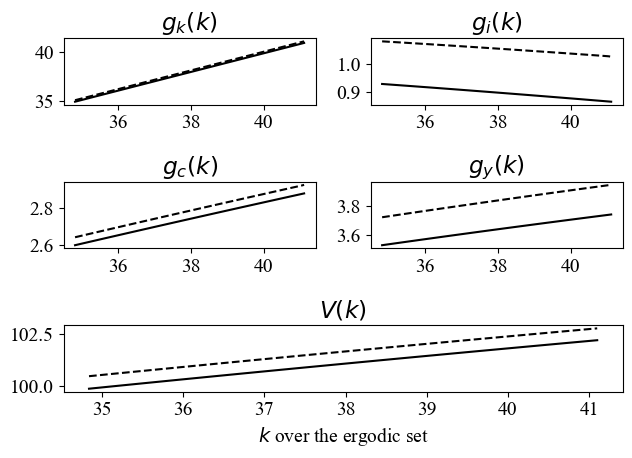

In [19]:
# import required modules
from matplotlib.gridspec import GridSpec

if solvemodel == 'y':
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "14"

    # create objects
    fig1 = plt.figure(constrained_layout=True)
    gs = GridSpec(3, 2, figure=fig1)

    # create sub plots as grid
    ax1 = fig1.add_subplot(gs[0, 0])
    ax2 = fig1.add_subplot(gs[0, 1])
    ax3 = fig1.add_subplot(gs[1, 0])
    ax4 = fig1.add_subplot(gs[1, 1])
    ax5 = fig1.add_subplot(gs[2, :])

    ax1.plot(SSK, gk[:,1], 'k-')
    ax1.plot(SSK, gk[:,-1], 'k--')
    ax1.set(title='$g_{k}(k)$')

    ax2.plot(SSK, gi[:,1], 'k-')
    ax2.plot(SSK, gi[:,-1], 'k--')
    ax2.set(title='$g_{i}(k)$')

    ax3.plot(SSK, gc[:,1], 'k-')
    ax3.plot(SSK, gc[:,-1], 'k--')
    ax3.set(title='$g_{c}(k)$')

    ax4.plot(SSK, gy[:,1], 'k-')
    ax4.plot(SSK, gy[:,-1], 'k--')
    ax4.set(title='$g_{y}(k)$')

    ax5.plot(SSK, v[:,1], 'k-')
    ax5.plot(SSK, v[:,-1], 'k--')
    ax5.set(xlabel = '$k$ over the ergodic set', title='$V(k)$')


    plt.tight_layout()
    plt.savefig('growth_pi_eff_value_policy.jpg', dpi=800)
    plt.show()
    plt.close(fig1)

In [20]:
#!jupyter nbconvert --to script growth_pi_eff.ipynb